In [1]:
import warnings
warnings.filterwarnings('ignore')

import csv 
import sys
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Bidirectional, RepeatVector, TimeDistributed, Input, Flatten, Dropout

from statsmodels.tools.eval_measures import rmse
from tabulate import tabulate

Using TensorFlow backend.


In [2]:
covid19_us = pd.read_csv("../data/covid19_US.csv")
covid19_us.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
covid19_us = covid19_us.set_index("Date")
covid19_us

,Confirmed
Date,
1/22/20,1
1/23/20,1
1/24/20,2
1/25/20,2
1/26/20,5
...,...
5/13/20,1390406
5/14/20,1417774
5/15/20,1442824


In [3]:
train_data = covid19_us[:len(covid19_us)-3]
test_data = covid19_us[len(covid19_us)-3:]

In [4]:
scalar = MinMaxScaler()
scalar.fit(train_data)
scaled_train_data = scalar.transform(train_data)
scaled_test_data = scalar.transform(test_data)

In [5]:
steps = 3
n_features = 1 
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length = steps, batch_size=1)

## 1. Train Model 

In [6]:
model_bidirectional = Sequential()
model_bidirectional.add(Bidirectional(LSTM(200, activation='relu'), input_shape=(steps, n_features)))
model_bidirectional.add(Dense(1))
model_bidirectional.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model_bidirectional.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 400)               323200    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 401       
Total params: 323,601
Trainable params: 323,601
Non-trainable params: 0
_________________________________________________________________


In [8]:
model_bidirectional.fit_generator(generator, epochs=20)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
111/111 [==============================] - 1s 11ms/step - loss: 0.0235
Epoch 2/20
111/111 [==============================] - 1s 5ms/step - loss: 1.6281e-04
Epoch 3/20
111/111 [==============================] - 1s 6ms/step - loss: 1.4749e-04
Epoch 4/20
111/111 [==============================] - 1s 5ms/step - loss: 7.9287e-05
Epoch 5/20
111/111 [==============================] - 1s 6ms/step - loss: 6.6316e-05
Epoch 6/20
111/111 [==============================] - 1s 5ms/step - loss: 9.4156e-05
Epoch 7/20
111/111 [==============================] - 1s 6ms/step - loss: 3.5158e-05
Epoch 8/20
111/111 [==============================] - 1s 5ms/step - loss: 7.5253e-05
Epoch 9/20
111/111 [==============================] - 1s 5ms/step - loss: 3.9906e-05
Epoch 10/20
111/111 [==============================] - 1s 5ms/step - loss: 4.2964e-05
Epoch 11/20
111/111 [==============================] - 1s 5ms/step - loss: 2.4948e-05
Epoch 12/20
111/11

In [9]:
losses_bidirectional = model_bidirectional.history.history["loss"]

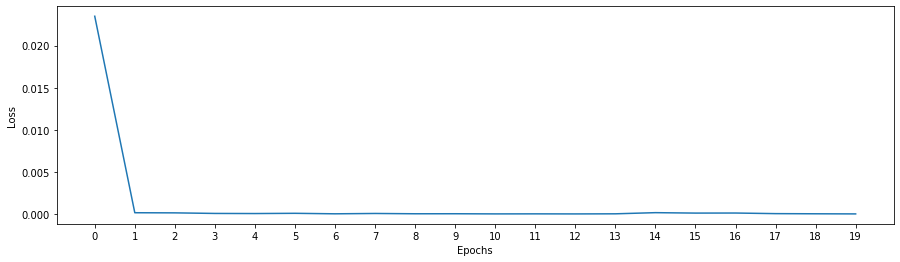

In [10]:
plt.figure(figsize=(15,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_bidirectional)), losses_bidirectional)

## 2. Test Model 

In [11]:
prediction_scaled_bidirectional = list()

batch = scaled_train_data[-steps:]
curr_batch = batch.reshape((1, steps, n_features))

for i in range(len(test_data)): 
    pred_bidirectional = model_bidirectional.predict(curr_batch)[0]
    prediction_scaled_bidirectional.append(pred_bidirectional)
    curr_batch = np.append(curr_batch[:, 1:, :], [[pred_bidirectional]], axis=1)
    
prediction_scaled_bidirectional

[array([1.0113204], dtype=float32),
 array([1.0265187], dtype=float32),
 array([1.0422199], dtype=float32)]

In [12]:
prediction_bidirectional = scalar.inverse_transform(prediction_scaled_bidirectional)
prediction_bidirectional

array([[1433823.690202  ],
       [1455371.50040948],
       [1477632.2020185 ]])

In [13]:
test_data["LSTM_Predictions"] = prediction_bidirectional
test_data

,Confirmed,LSTM_Predictions
Date,,
5/15/20,1442824,1.433824e+06
5/16/20,1467820,1.455372e+06
5/17/20,1486757,1.477632e+06


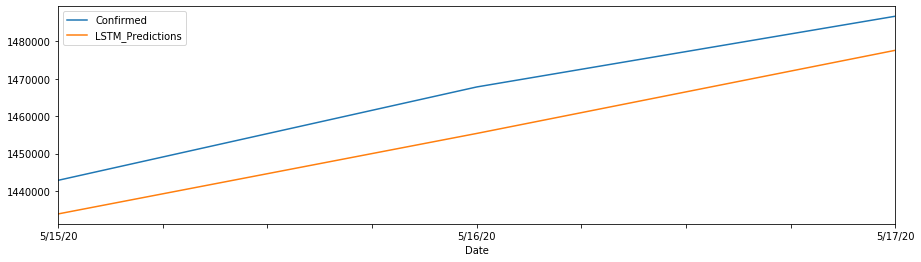

In [14]:
test_data['Confirmed'].plot(figsize = (15,4), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [15]:
lstm_rmse_error_bidirectional = rmse(test_data['Confirmed'], test_data["LSTM_Predictions"])
lstm_mse_error_bidirectional = lstm_rmse_error_bidirectional**2
mean_value = covid19_us['Confirmed'].mean()

print('MSE Error:', lstm_mse_error_bidirectional, '\nRMSE Error:', lstm_rmse_error_bidirectional, '\nMean:',mean_value)


MSE Error: 106410885.5727641 
RMSE Error: 10315.565208594442 
Mean: 364899.452991453


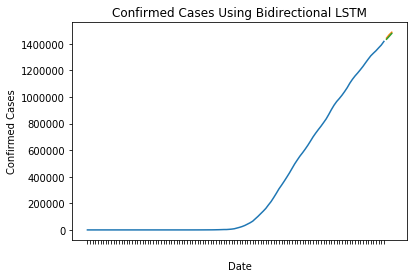

In [48]:
plt.plot(train_data["Confirmed"])
plt.plot(test_data["Confirmed"])
plt.plot(test_data["LSTM_Predictions"])
plt.ylabel("Confirmed Cases")
plt.xlabel("Date")
plt.title("Confirmed Cases Using Bidirectional LSTM")
plt.xticks(train_data.index, " ")
plt.show()

## Let's zoom in a bit closer 

In [44]:
shorted_train_data = train_data.loc["5/5/20":"5/14/20"]

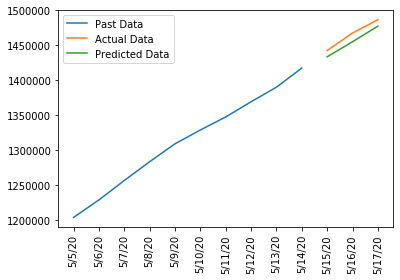

In [49]:
plt.plot(shorted_train_data["Confirmed"], label="Past Data")
plt.plot(test_data["Confirmed"], label= "Actual Data")
plt.plot(test_data["LSTM_Predictions"], label = "Predicted Data")
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [19]:
test_data

,Confirmed,LSTM_Predictions
Date,,
5/15/20,1442824,1.433824e+06
5/16/20,1467820,1.455372e+06
5/17/20,1486757,1.477632e+06
